Lennard-Jones Fluid


In [29]:
import matplotlib.pyplot as plt
import numpy as np
import math


In [ ]:
def energy_LJ(r, epsilon=1.0, sigma=1.0):
    '''Calculate Lennard-Jones potential energy for distance r.'''
    if r == 0:
        return 0 
    sr6 = (sigma / r) ** 6
    sr12 = sr6 ** 2      
    return 4 * epsilon * (sr12 - sr6)

def union_of_neighbors(old_row, old_col, new_row, new_col):
    '''Return the set of all neighbor cells for both the old and new cell positions.'''
    neighbors = set()
    for i in range(-1, 2):
        for j in range(-1, 2):
            neighbors.add(((old_row + i), (old_col + j)))
            neighbors.add(((new_row + i), (new_col + j)))
    return neighbors

def MC_Lennard_Jones(N, L, T, n_steps, dx, rc):
    '''Perform Monte Carlo simulation for Lennard-Jones fluid.'''
    # Devide the box up into a grid, to have a cut-off for the interaction potential.
    gridsize = int(np.floor(L/rc))  # Number of cells in each direction.
    
    # The square box is divided into gridsize x gridsize cells.
    # All particles are placed randomly in the grid cells, having an equal distribution among the grid cells.    
    Pos = np.zeros((N,2)) 
    for i in range(N):
        Pos[i, 0] = (np.random.rand() * (gridsize - 1) + 0.5) * rc
        Pos[i, 1] = (np.random.rand() * (gridsize - 1) + 0.5) * rc

    All_pos = np.zeros((N,2,n_steps))
    All_pos[:,:,0] = Pos.copy()

    cell_list = {} # The slowest part of the algorithm is the check that the updated particle position is not overlapping with any of the other N particles. 
    # We generate a list which associate to each particle the given cell. 
    # If the position update brings the particle in the l-th cell, we check that acceptance with any of the particles in the cell l plus eventually some of its neighboring cells.
    for i in range(N):
        rowcell = int(Pos[i,0]//rc)
        collumncell = int(Pos[i,1]//rc)
        if (rowcell, collumncell) not in cell_list:
            cell_list[(rowcell, collumncell)] = [i]
        else:
            cell_list[(rowcell, collumncell)].append(i)
    # Cell_list is a dictionary with the keys the cell row and collumns (cell has size rc x rc) and the values the particles in the cell.
    # -> cell_list = {(row, collumn): [particle1, particle2, ...]}
    
    for i in range(n_steps):
        particle = np.random.randint(N) # Pick a random particle
        # Propose a new position for the particle, small perturbation [-dx/2, dx/2] around current position 
        new_pos = (Pos[particle] + (np.random.rand(2) - 0.5) * dx)%L
        # Check for energy with other particles in the same and neighboring cells
        rowcell = int(new_pos[0] // rc)
        collumncell = int(new_pos[1] // rc)
        old_rowcell = int(Pos[particle][0] // rc)
        old_collumncell = int(Pos[particle][1] // rc)
        
        # Calculate energy difference (E_new - E_old)
        dE = 0
        neighbors = union_of_neighbors(old_rowcell, old_collumncell, rowcell, collumncell)
        for cell in neighbors:
            # Apply periodic boundary conditions to cell indices
            cell_mod = (cell[0] % gridsize, cell[1] % gridsize)
            for other_particle in cell_list.get(cell_mod, []):
                if other_particle != particle:
                    r_old = np.sqrt(np.sum((Pos[particle] - Pos[other_particle])**2))  
                    r_new = np.sqrt(np.sum((new_pos - Pos[other_particle])**2))
                    dE += energy_LJ(r_new) - energy_LJ(r_old)
                    
        # Accept or reject the move
        if dE <= 0 or np.random.rand() < np.exp(-dE / T):
            # Remove particle from old cell
            cell_list[(old_rowcell, old_collumncell)].remove(particle)
            Pos[particle] = new_pos  # Accept the move
            # Update cell list
            rowcell = int(new_pos[0] // rc)
            collumncell = int(new_pos[1] // rc)
            if (rowcell, collumncell) not in cell_list:
                cell_list[(rowcell, collumncell)] = [particle]
            else:
                cell_list[(rowcell, collumncell)].append(particle)
        All_pos[:,:,i] = Pos.copy()
    return All_pos



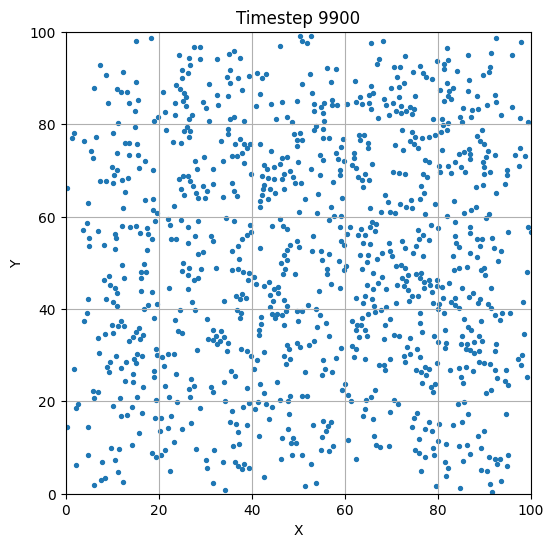

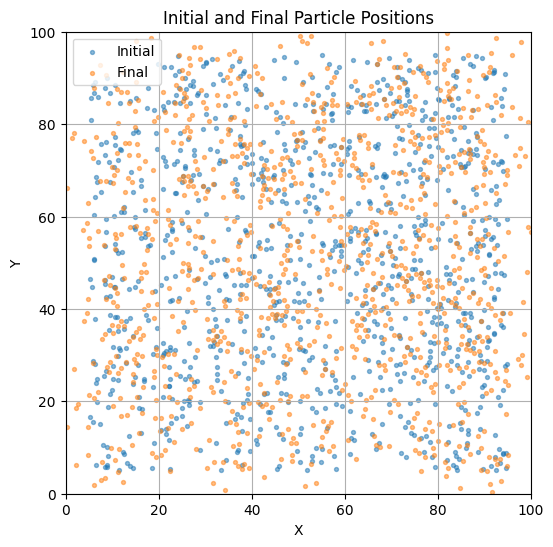

In [57]:
from IPython.display import display, clear_output

L = 100  # Size of the box
N = 1000    # Number of particles
rc = 10
T = 1
n_steps = 10000
dx = 5
all_positions = MC_Lennard_Jones(N, L, T, n_steps, dx, rc)

fig, ax = plt.subplots(figsize=(6,6))
positions = all_positions[:,:,0]
scat = ax.scatter(positions[:,0], positions[:,1], s=8)
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()


for i in range(0, n_steps, 100):
    positions = all_positions[:,:,i]
    scat.set_offsets(positions)
    ax.set_title(f"Timestep {i}")
    clear_output(wait=True)
    display(fig)
    plt.pause(0.01)

# plot the first and last frame on the same plot, different colors
plt.figure(figsize=(6,6))
plt.scatter(all_positions[:,0,0], all_positions[:,1,0], s=8, label='Initial', alpha=0.5)
plt.scatter(all_positions[:,0,-1], all_positions[:,1,-1], s=8, label='Final', alpha=0.5)
plt.xlim(0, L)
plt.ylim(0, L)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Initial and Final Particle Positions')
plt.legend()
plt.grid()
plt.show()

